In [1]:
# Section 1: Setup and Data Preparation
# -----------------------------------------
# This section imports necessary libraries, loads the dataset, and defines
# the features and targets for the color prediction model. We also split
# the data into training and test sets.

import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import os
from skimage import color as skcolor

data = pd.read_csv("/Users/xiaos/Downloads/Suinan_train_data_cleaned_cleaned.csv")

features = ["Observed R", "Observed G", "Observed B", "Red R", "Red G", "Red B",
            "Green R", "Green G", "Green B", "Blue R", "Blue G", "Blue B"]
targets = ["True R", "True G", "True B"]

train_data, test_data = train_test_split(data, test_size=0.1, stratify=data["camera"], random_state=42)

def calculate_mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

def calculate_delta_e(true_rgb, pred_rgb):
    true_lab = skcolor.rgb2lab(np.array([true_rgb]))
    pred_lab = skcolor.rgb2lab(np.array([pred_rgb]))
    delta_e = np.sqrt(np.sum((true_lab - pred_lab) ** 2, axis=1))
    return delta_e[0]

In [2]:
# Section 2: Model Training with Cross-Validation
# -----------------------------------------
# This section implements k-fold cross-validation to train XGBoost models
# for each color channel (R, G, B) separately. We track performance metrics
# for each fold and calculate average performance across folds.

n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)

cv_results = {
    'R': {'mae': [], 'rmse': [], 'r2': [], 'mape': [], 'fold_models': []},
    'G': {'mae': [], 'rmse': [], 'r2': [], 'mape': [], 'fold_models': []},
    'B': {'mae': [], 'rmse': [], 'r2': [], 'mape': [], 'fold_models': []}
}

print("Performing cross-validation...")
for color in ["R", "G", "B"]:
    print(f"Training models for {color} channel")
    
    y = train_data[f"True {color}"]
    X = train_data[features]
    
    fold = 1
    for train_idx, val_idx in kf.split(X):
        X_fold_train, X_fold_val = X.iloc[train_idx], X.iloc[val_idx]
        y_fold_train, y_fold_val = y.iloc[train_idx], y.iloc[val_idx]
        
        model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
        model.fit(X_fold_train, y_fold_train)
        
        preds = model.predict(X_fold_val)
        preds = np.clip(np.round(preds), 0, 255)
        
        fold_mae = mean_absolute_error(y_fold_val, preds)
        fold_rmse = np.sqrt(mean_squared_error(y_fold_val, preds))
        fold_r2 = r2_score(y_fold_val, preds)
        fold_mape = calculate_mape(y_fold_val, preds)
        
        cv_results[color]['mae'].append(fold_mae)
        cv_results[color]['rmse'].append(fold_rmse)
        cv_results[color]['r2'].append(fold_r2)
        cv_results[color]['mape'].append(fold_mape)
        cv_results[color]['fold_models'].append(model)
        
        print(f"  Fold {fold}: MAE = {fold_mae:.2f}, RMSE = {fold_rmse:.2f}, R² = {fold_r2:.3f}, MAPE = {fold_mape:.2f}%")
        fold += 1
    
    avg_mae = np.mean(cv_results[color]['mae'])
    avg_rmse = np.mean(cv_results[color]['rmse'])
    avg_r2 = np.mean(cv_results[color]['r2'])
    avg_mape = np.mean(cv_results[color]['mape'])
    
    print(f"  Average for {color}: MAE = {avg_mae:.2f}, RMSE = {avg_rmse:.2f}, R² = {avg_r2:.3f}, MAPE = {avg_mape:.2f}%")
    print()

final_models = {}
best_fold_models = {}

for color in ["R", "G", "B"]:
    best_fold = np.argmin(cv_results[color]['mae'])
    best_fold_models[color] = cv_results[color]['fold_models'][best_fold]
    
    final_models[color] = xgb.XGBRegressor(objective="reg:squarederror", random_state=42)
    final_models[color].fit(train_data[features], train_data[f"True {color}"])


Performing cross-validation...
Training models for R channel
  Fold 1: MAE = 14.89, RMSE = 27.85, R² = 0.216, MAPE = 7.76%
  Fold 2: MAE = 9.66, RMSE = 22.35, R² = 0.563, MAPE = 4.85%
  Fold 3: MAE = 13.68, RMSE = 31.38, R² = 0.400, MAPE = 8.76%
  Fold 4: MAE = 11.78, RMSE = 22.38, R² = 0.596, MAPE = 6.07%
  Fold 5: MAE = 12.12, RMSE = 29.02, R² = 0.393, MAPE = 7.90%
  Average for R: MAE = 12.43, RMSE = 26.60, R² = 0.434, MAPE = 7.07%

Training models for G channel
  Fold 1: MAE = 3.17, RMSE = 6.54, R² = 0.932, MAPE = 1.76%
  Fold 2: MAE = 2.99, RMSE = 6.38, R² = 0.942, MAPE = 1.88%
  Fold 3: MAE = 3.06, RMSE = 6.19, R² = 0.942, MAPE = 1.96%
  Fold 4: MAE = 4.46, RMSE = 9.60, R² = 0.892, MAPE = 3.71%
  Fold 5: MAE = 2.05, RMSE = 4.07, R² = 0.974, MAPE = 1.18%
  Average for G: MAE = 3.15, RMSE = 6.56, R² = 0.936, MAPE = 2.10%

Training models for B channel
  Fold 1: MAE = 3.12, RMSE = 5.76, R² = 0.962, MAPE = 1.87%
  Fold 2: MAE = 3.62, RMSE = 7.42, R² = 0.936, MAPE = 2.40%
  Fold 3: MA

In [3]:
# Section 3: Model Evaluation
# -----------------------------------------
# This section evaluates both the best cross-validation fold models and the models
# trained on the full training set using the test data. We calculate various
# performance metrics and analyze error distributions.

def evaluate_models(models, test_data, label="Model"):
    predictions = {}
    metrics = {
        'mae': {},
        'rmse': {},
        'r2': {},
        'mape': {}
    }
    delta_e_values = []
    
    for color in ["R", "G", "B"]:
        predictions[color] = models[color].predict(test_data[features])
        predictions[color] = np.clip(np.round(predictions[color]), 0, 255)
        
        metrics['mae'][color] = mean_absolute_error(test_data[f"True {color}"], predictions[color])
        metrics['rmse'][color] = np.sqrt(mean_squared_error(test_data[f"True {color}"], predictions[color]))
        metrics['r2'][color] = r2_score(test_data[f"True {color}"], predictions[color])
        metrics['mape'][color] = calculate_mape(test_data[f"True {color}"], predictions[color])
    
    overall_mae = np.mean([metrics['mae'][c] for c in ["R", "G", "B"]])
    overall_rmse = np.mean([metrics['rmse'][c] for c in ["R", "G", "B"]])
    overall_r2 = np.mean([metrics['r2'][c] for c in ["R", "G", "B"]])
    overall_mape = np.mean([metrics['mape'][c] for c in ["R", "G", "B"]])
    
    for i in range(len(test_data)):
        true_rgb = [
            test_data["True R"].iloc[i] / 255.0,
            test_data["True G"].iloc[i] / 255.0,
            test_data["True B"].iloc[i] / 255.0
        ]
        pred_rgb = [
            predictions["R"][i] / 255.0,
            predictions["G"][i] / 255.0,
            predictions["B"][i] / 255.0
        ]
        delta_e = calculate_delta_e(true_rgb, pred_rgb)
        delta_e_values.append(delta_e)
    
    mean_delta_e = np.mean(delta_e_values)
    median_delta_e = np.median(delta_e_values)
    
    print(f"{label} performance metrics:")
    for color in ["R", "G", "B"]:
        print(f"  {color}: MAE = {metrics['mae'][color]:.2f}, RMSE = {metrics['rmse'][color]:.2f}, R² = {metrics['r2'][color]:.3f}, MAPE = {metrics['mape'][color]:.2f}%")
    
    print(f"  Overall: MAE = {overall_mae:.2f}, RMSE = {overall_rmse:.2f}, R² = {overall_r2:.3f}, MAPE = {overall_mape:.2f}%")
    print(f"  Color space (ΔE): Mean = {mean_delta_e:.2f}, Median = {median_delta_e:.2f}")
    
    return predictions, metrics, overall_mae, delta_e_values

print("\nEvaluating on test set...")

best_fold_preds, best_fold_metrics, best_fold_overall_mae, best_fold_delta_e = evaluate_models(best_fold_models, test_data, "Best CV Fold Model")

final_preds, final_metrics, final_overall_mae, final_delta_e = evaluate_models(final_models, test_data, "Full Training Set Model")

if best_fold_overall_mae <= final_overall_mae:
    print("\nUsing best cross-validation fold models for visualization")
    predictions = best_fold_preds
    metrics = best_fold_metrics
    overall_mae = best_fold_overall_mae
    delta_e_values = best_fold_delta_e
else:
    print("\nUsing full training set models for visualization")
    predictions = final_preds
    metrics = final_metrics
    overall_mae = final_overall_mae
    delta_e_values = final_delta_e

results = test_data.copy()
results["Predicted R"] = predictions["R"]
results["Predicted G"] = predictions["G"] 
results["Predicted B"] = predictions["B"]

results["R_Abs_Error"] = np.abs(results["True R"] - results["Predicted R"])
results["G_Abs_Error"] = np.abs(results["True G"] - results["Predicted G"])
results["B_Abs_Error"] = np.abs(results["True B"] - results["Predicted B"])

results["Color Difference"] = np.sqrt(
    (results["True R"] - results["Predicted R"])**2 +
    (results["True G"] - results["Predicted G"])**2 +
    (results["True B"] - results["Predicted B"])**2
)

results["Delta E"] = delta_e_values

print("\n==== MAE THRESHOLD ANALYSIS ====")
mae_thresholds = [0, 5, 20, 50]

print("\nPercentage of predictions within specified MAE thresholds:")
channel_results = {}

for color in ["R", "G", "B"]:
    channel_results[color] = {}
    error_col = f"{color}_Abs_Error"
    
    for threshold in mae_thresholds:
        within_threshold = (results[error_col] <= threshold).sum()
        percentage = (within_threshold / len(results)) * 100
        channel_results[color][threshold] = percentage
        
        print(f"  {color} channel - Within MAE {threshold}: {percentage:.2f}%")


Evaluating on test set...
Best CV Fold Model performance metrics:
  R: MAE = 10.70, RMSE = 22.67, R² = 0.722, MAPE = 5.41%
  G: MAE = 3.51, RMSE = 7.81, R² = 0.903, MAPE = 2.13%
  B: MAE = 4.24, RMSE = 8.51, R² = 0.901, MAPE = 2.57%
  Overall: MAE = 6.15, RMSE = 13.00, R² = 0.842, MAPE = 3.37%
  Color space (ΔE): Mean = 5.88, Median = 2.51
Full Training Set Model performance metrics:
  R: MAE = 10.04, RMSE = 21.50, R² = 0.750, MAPE = 5.18%
  G: MAE = 3.19, RMSE = 7.83, R² = 0.902, MAPE = 1.90%
  B: MAE = 3.26, RMSE = 8.14, R² = 0.909, MAPE = 1.99%
  Overall: MAE = 5.50, RMSE = 12.49, R² = 0.854, MAPE = 3.02%
  Color space (ΔE): Mean = 5.10, Median = 0.63

Using full training set models for visualization

==== MAE THRESHOLD ANALYSIS ====

Percentage of predictions within specified MAE thresholds:
  R channel - Within MAE 0: 38.57%
  R channel - Within MAE 5: 61.43%
  R channel - Within MAE 20: 87.14%
  R channel - Within MAE 50: 94.29%
  G channel - Within MAE 0: 60.00%
  G channel - W


Visualization saved as '/Users/xiaos/Downloads/project1/color_comparison_metrics_cv.png'
Results saved as '/Users/xiaos/Downloads/project1/color_prediction_results_with_metrics_cv.csv'
MAE threshold analysis saved as '/Users/xiaos/Downloads/project1/mae_threshold_analysis.png'

==== COMPREHENSIVE PERFORMANCE SUMMARY ====
Per channel metrics:
  R: MAE = 10.04, RMSE = 21.50, R² = 0.750, MAPE = 5.18%
  G: MAE = 3.19, RMSE = 7.83, R² = 0.902, MAPE = 1.90%
  B: MAE = 3.26, RMSE = 8.14, R² = 0.909, MAPE = 1.99%

Overall metrics:
  MAE = 5.50, RMSE = 12.49, R² = 0.854, MAPE = 3.02%

Color space accuracy (ΔE):
  Mean ΔE = 5.10
  Median ΔE = 0.63
  Max ΔE = 53.28
  Min ΔE = 0.00

MAE Threshold Analysis Summary:
  Within MAE 0: R=38.57%, G=60.00%, B=58.57%, Avg=52.38%
  Within MAE 5: R=61.43%, G=82.86%, B=84.29%, Avg=76.19%
  Within MAE 20: R=87.14%, G=97.14%, B=95.71%, Avg=93.33%
  Within MAE 50: R=94.29%, G=100.00%, B=100.00%, Avg=98.10%


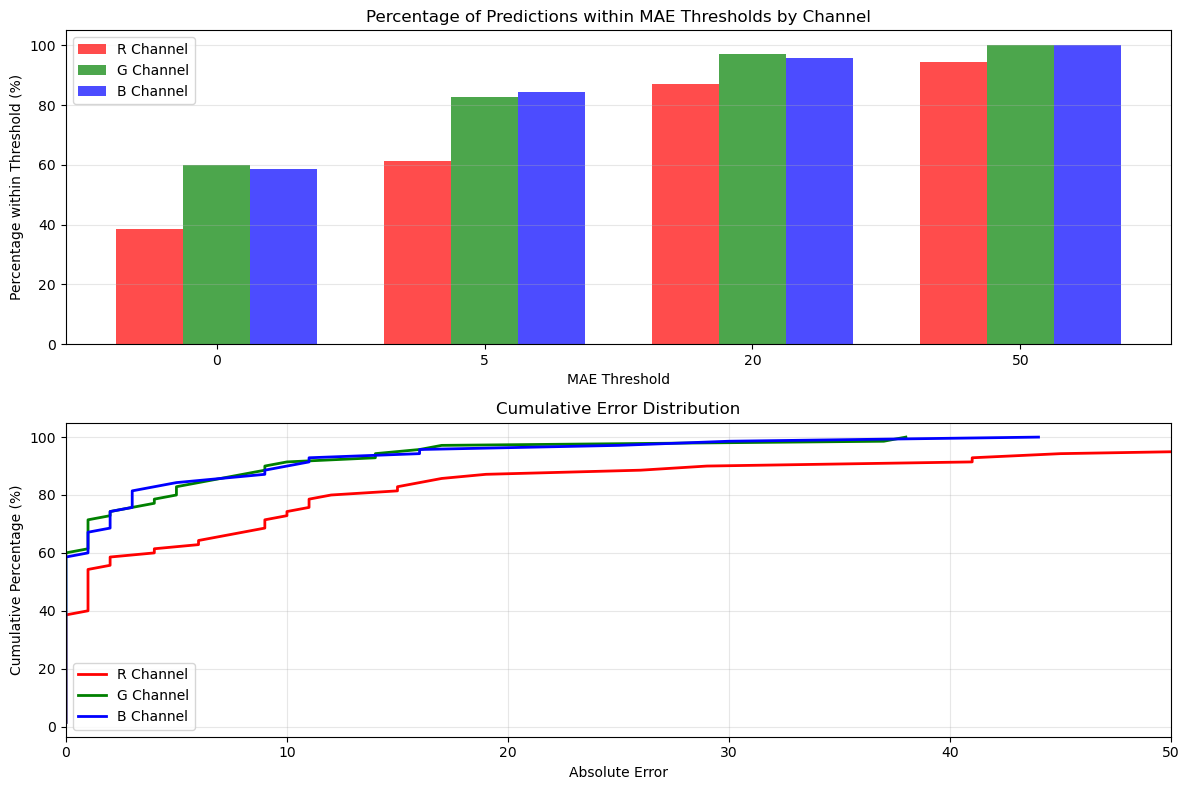

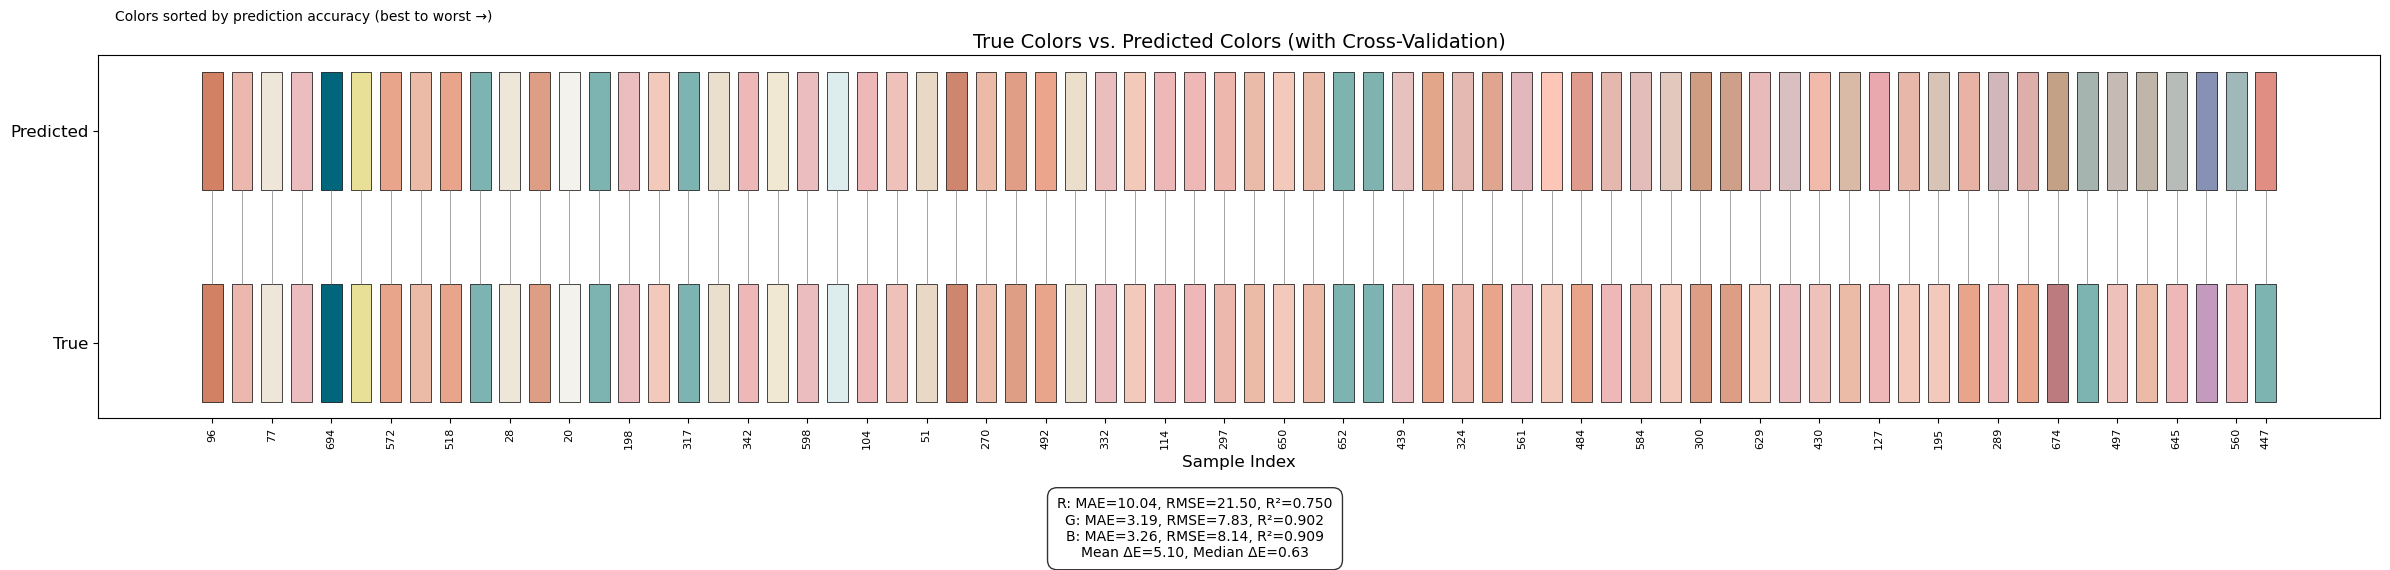

In [4]:
# Section 4: Visualization and Result Export
# -----------------------------------------
# This section creates visualizations of the model performance including MAE
# threshold analysis, color comparison between true and predicted colors, and 
# generates comprehensive performance reports. Results are also exported.

# Create a combined figure for threshold analysis
plt.figure(figsize=(12, 8))

# Bar chart for threshold analysis
bar_width = 0.25
index = np.arange(len(mae_thresholds))

plt.subplot(2, 1, 1)
plt.bar(index - bar_width, [channel_results['R'][t] for t in mae_thresholds], bar_width, 
       label='R Channel', color='red', alpha=0.7)
plt.bar(index, [channel_results['G'][t] for t in mae_thresholds], bar_width, 
       label='G Channel', color='green', alpha=0.7)
plt.bar(index + bar_width, [channel_results['B'][t] for t in mae_thresholds], bar_width, 
       label='B Channel', color='blue', alpha=0.7)

plt.xlabel('MAE Threshold')
plt.ylabel('Percentage within Threshold (%)')
plt.title('Percentage of Predictions within MAE Thresholds by Channel')
plt.xticks(index, mae_thresholds)
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Cumulative error distribution plot
plt.subplot(2, 1, 2)
for color, c, label in zip(["R", "G", "B"], ['red', 'green', 'blue'], ['R Channel', 'G Channel', 'B Channel']):
    error_values = sorted(results[f"{color}_Abs_Error"])
    cumulative = np.arange(1, len(error_values) + 1) / len(error_values) * 100
    plt.plot(error_values, cumulative, color=c, label=label, linewidth=2)

plt.grid(True, alpha=0.3)
plt.xlabel('Absolute Error')
plt.ylabel('Cumulative Percentage (%)')
plt.title('Cumulative Error Distribution')
plt.legend()
plt.xlim(0, 50)  

plt.tight_layout()
output_dir = "/Users/xiaos/Downloads/project1"
os.makedirs(output_dir, exist_ok=True)
plt.savefig(os.path.join(output_dir, "mae_threshold_analysis.png"), dpi=300)


samples = results.sort_values("Color Difference")

samples = samples.reset_index()
samples = samples.rename(columns={'index': 'original_index'})
original_indices = samples['original_index'].tolist()


def rgb_to_hex(r, g, b):
    return rgb2hex((r/255, g/255, b/255))

samples["True Color Hex"] = samples.apply(
    lambda row: rgb_to_hex(row["True R"], row["True G"], row["True B"]), axis=1
)
samples["Predicted Color Hex"] = samples.apply(
    lambda row: rgb_to_hex(row["Predicted R"], row["Predicted G"], row["Predicted B"]), axis=1
)

plt.figure(figsize=(24, 6))  


block_width = max(0.35, min(0.9, 20.0/len(samples)))

for i in range(len(samples)):
    plt.fill_between(
        [i-block_width, i+block_width], 
        [0.15, 0.15], 
        [0.4, 0.4], 
        color=samples.iloc[i]["True Color Hex"],
        edgecolor='black',
        linewidth=0.5
    )
    

    plt.fill_between(
        [i-block_width, i+block_width], 
        [0.6, 0.6], 
        [0.85, 0.85], 
        color=samples.iloc[i]["Predicted Color Hex"],
        edgecolor='black',
        linewidth=0.5
    )
    

    plt.plot([i, i], [0.4, 0.6], color='gray', linestyle='-', linewidth=0.5)

plt.ylabel("")  
plt.xlabel("Sample Index", fontsize=12)  


plt.title("True Colors vs. Predicted Colors (with Cross-Validation)", fontsize=14)
plt.yticks([0.275, 0.725], ["True", "Predicted"], fontsize=12)


n_ticks = min(30, len(samples))
stride = max(1, len(samples) // n_ticks)
tick_positions = list(range(0, len(samples), stride))
if tick_positions and tick_positions[-1] != len(samples) - 1:
    tick_positions.append(len(samples) - 1)  

plt.xticks(tick_positions, [original_indices[i] for i in tick_positions], fontsize=8, rotation=90)
plt.grid(False)

r_metrics = f"R: MAE={metrics['mae']['R']:.2f}, RMSE={metrics['rmse']['R']:.2f}, R²={metrics['r2']['R']:.3f}"
g_metrics = f"G: MAE={metrics['mae']['G']:.2f}, RMSE={metrics['rmse']['G']:.2f}, R²={metrics['r2']['G']:.3f}"
b_metrics = f"B: MAE={metrics['mae']['B']:.2f}, RMSE={metrics['rmse']['B']:.2f}, R²={metrics['r2']['B']:.3f}"
delta_e_metrics = f"Mean ΔE={np.mean(delta_e_values):.2f}, Median ΔE={np.median(delta_e_values):.2f}"

plt.figtext(0.5, 0.03, f"{r_metrics}\n{g_metrics}\n{b_metrics}\n{delta_e_metrics}", 
           ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, pad=0.7))


plt.figtext(0.05, 0.93, "Colors sorted by prediction accuracy (best to worst →)", 
           fontsize=10, ha='left', va='center')


plt.tight_layout(rect=[0, 0.15, 1, 0.93])  
visualization_file = os.path.join(output_dir, "color_comparison_metrics_cv.png")
plt.savefig(visualization_file, dpi=300, bbox_inches='tight')
output_file = os.path.join(output_dir, "color_prediction_results_with_metrics_cv.csv")
columns_to_save = ["camera", 
                  "True R", "True G", "True B", 
                  "Predicted R", "Predicted G", "Predicted B",
                  "R_Abs_Error", "G_Abs_Error", "B_Abs_Error",
                  "Color Difference", "Delta E"]
results[columns_to_save].to_csv(output_file, index=False)

print(f"\nVisualization saved as '{visualization_file}'")
print(f"Results saved as '{output_file}'")
print(f"MAE threshold analysis saved as '{os.path.join(output_dir, 'mae_threshold_analysis.png')}'")
print("\n==== COMPREHENSIVE PERFORMANCE SUMMARY ====")
print("Per channel metrics:")
for color in ["R", "G", "B"]:
    print(f"  {color}: MAE = {metrics['mae'][color]:.2f}, RMSE = {metrics['rmse'][color]:.2f}, R² = {metrics['r2'][color]:.3f}, MAPE = {metrics['mape'][color]:.2f}%")

print("\nOverall metrics:")
overall_r2 = np.mean([metrics['r2'][c] for c in ["R", "G", "B"]])
overall_rmse = np.mean([metrics['rmse'][c] for c in ["R", "G", "B"]])
overall_mape = np.mean([metrics['mape'][c] for c in ["R", "G", "B"]])
print(f"  MAE = {overall_mae:.2f}, RMSE = {overall_rmse:.2f}, R² = {overall_r2:.3f}, MAPE = {overall_mape:.2f}%")

print("\nColor space accuracy (ΔE):")
print(f"  Mean ΔE = {np.mean(delta_e_values):.2f}")
print(f"  Median ΔE = {np.median(delta_e_values):.2f}")
print(f"  Max ΔE = {np.max(delta_e_values):.2f}")
print(f"  Min ΔE = {np.min(delta_e_values):.2f}")

# Print detailed MAE threshold analysis
print("\nMAE Threshold Analysis Summary:")
for threshold in mae_thresholds:
    r_pct = channel_results['R'][threshold]
    g_pct = channel_results['G'][threshold]
    b_pct = channel_results['B'][threshold]
    avg_pct = (r_pct + g_pct + b_pct) / 3
    
    print(f"  Within MAE {threshold}: R={r_pct:.2f}%, G={g_pct:.2f}%, B={b_pct:.2f}%, Avg={avg_pct:.2f}%")